## High frequecny (original) scale for STL decomposition and regerssion results (NOTE: TOO ILLIQUID -> NO SENSE TO USE)

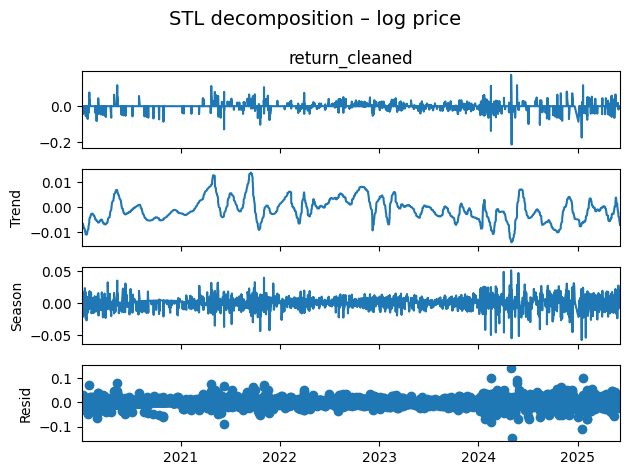

In [86]:
stl = STL(spot['return_cleaned'].dropna(), period=40)              
res  = stl.fit()
fig  = res.plot()
fig.suptitle('STL decomposition – log price', fontsize=14)
plt.tight_layout()
plt.show()

In [87]:
spot.index = pd.to_datetime(spot.index)

spot['month'] = spot.index.month

dummies = pd.get_dummies(spot['month'], prefix='m', drop_first=True, dtype=float)

X = sm.add_constant(dummies)
model = sm.OLS(spot['return_cleaned'], X, missing='drop').fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.503
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           6.78e-05
Time:                        13:22:33   Log-Likelihood:                 8551.9
No. Observations:                3364   AIC:                        -1.708e+04
Df Residuals:                    3352   BIC:                        -1.701e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.001     -3.737      0.0

In [88]:
model_nw = model.get_robustcov_results(
    cov_type = 'HAC',
    maxlags = 1 
)

model_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.554
Date:                Thu, 19 Jun 2025   Prob (F-statistic):            0.00322
Time:                        13:22:38   Log-Likelihood:                 8551.9
No. Observations:                3364   AIC:                        -1.708e+04
Df Residuals:                    3352   BIC:                        -1.701e+04
Df Model:                          11                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.001     -3.044      0.002      -0.006      -0.001
m_2            0.0022      0.002      1.281      0.200      -0.001       0.006
m_3            0.0021      0.002      1.312      0.190      -0.001       0.005
m_4            0.0036      0.002      2.125      0.034       0.000       0.007
m_5            0.0035      0.002      1.807      0.071      -0.000       0.007
m_6            0.0049      0.002      3.106      0.002       0.002       0.008
m_7            0.0041      0.002      2.532      0.011       0.001       0.007
m_8            0.0034      0.002      2.089      0.037       0.000       0.007
m_9            0.0055      0.002      3.055      0.002       0.002       0.009
m_10          -0.0017      0.002     -0.829      0.407      -0.006       0.002
m_11           0.0059      0.002      2.905      0.004       0.002       0.010
m_12           0.0018      0.002      1.099      0.272      -0.001       0.005
==============================================================================
Omnibus:                      937.895   Durbin-Watson:                   1.474
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37146.327
Skew:                          -0.603   Prob(JB):                         0.00
Kurtosis:                      19.235   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

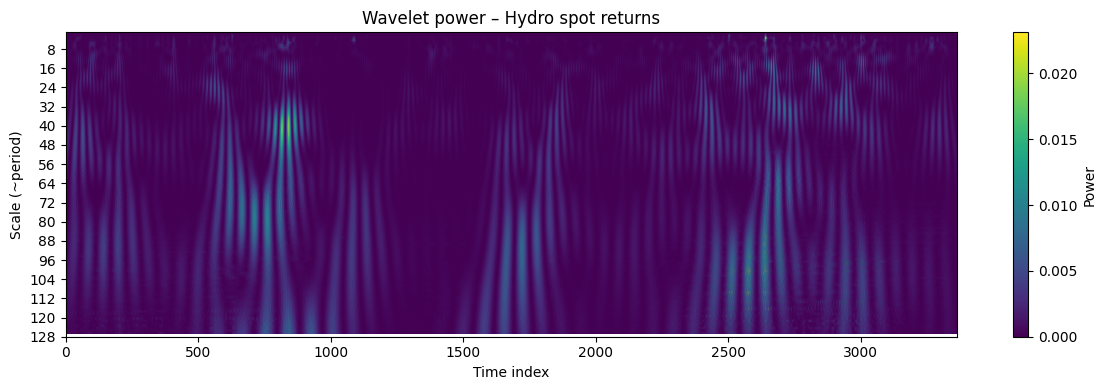

In [89]:
def wavelet_plot(series, scales=np.arange(1, 128), wavelet='morl',
                 title='Wavelet power – returns'):
    """Continuous wavelet transform & power spectrum plot."""
    coef, freqs = pywt.cwt(series.values, scales, wavelet, sampling_period=1)
    power = (np.abs(coef) ** 2)
    plt.figure(figsize=(12, 4))
    plt.imshow(power, extent=[0, len(series), scales.max(), scales.min()],
               cmap='viridis', aspect='auto')
    plt.yticks(np.arange(8, 129, 8))
    plt.xlabel('Time index'); plt.ylabel('Scale (~period)')
    plt.title(title); plt.colorbar(label='Power'); plt.tight_layout(); plt.show()

# example on stitched daily returns
wavelet_plot(spot['return_cleaned'].dropna(),
             title='Wavelet power – Hydro spot returns')


## Weakly scale -> no evidance

                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6805
Date:                Mon, 30 Jun 2025   Prob (F-statistic):              0.606
Time:                        09:07:48   Log-Likelihood:                 914.03
No. Observations:                 283   AIC:                            -1818.
Df Residuals:                     278   BIC:                            -1800.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -2.172      0.0

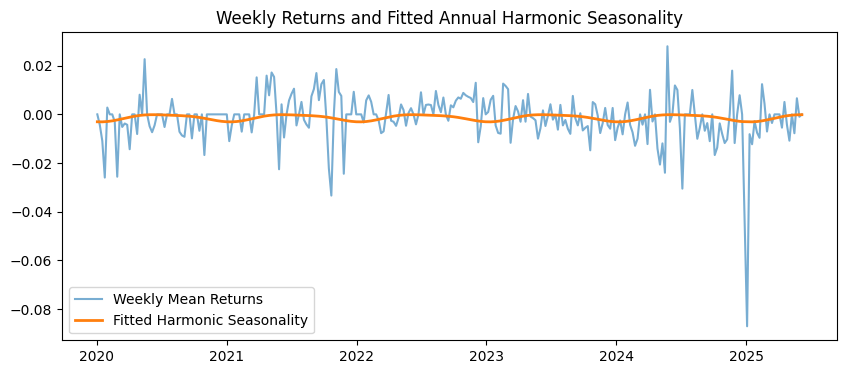

Text(0.5, 0.98, 'STL Decomposition (weekly)')

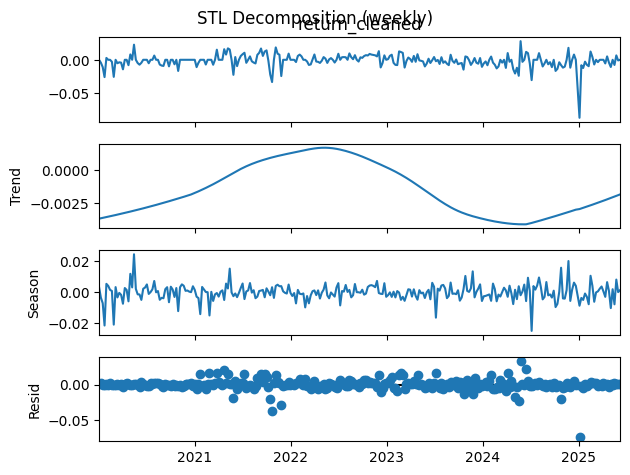

In [12]:
weekly = (
    spot['return_cleaned']
      .resample('W-FRI')   # or 'W-FRI', whichever aligns with your book
      .mean()
      .dropna()
)

# 2) Create a time index t = 0,1,2,… for each week
t = np.arange(len(weekly))

# 3) Build your Fourier terms for an annual cycle (≈52 weeks)
#    Here we include the first two harmonics; you can add more if needed.
fourier = pd.DataFrame({
    'sin1':  np.sin(2 * np.pi * t / 52),
    'cos1':  np.cos(2 * np.pi * t / 52),
    'sin2':  np.sin(4 * np.pi * t / 52),
    'cos2':  np.cos(4 * np.pi * t / 52),
}, index=weekly.index)

# 4) Assemble X & y
Xw = sm.add_constant(fourier)
yw = weekly

# 5) Fit with HAC(1) SEs to guard against serial correlation
model_w = sm.OLS(yw, Xw).fit(cov_type='HAC', cov_kwds={'maxlags':1})
print(model_w.summary())

# 6) If you want the fitted seasonal curve, predict it:
seasonal_fit = model_w.predict(Xw)

# 7) Plot actual vs. fitted seasonal component
plt.figure(figsize=(10,4))
plt.plot(yw.index, yw,    label='Weekly Mean Returns', alpha=0.6)
plt.plot(yw.index, seasonal_fit, 
         label='Fitted Harmonic Seasonality', linewidth=2)
plt.legend()
plt.title("Weekly Returns and Fitted Annual Harmonic Seasonality")
plt.show()


stl = STL(weekly, period=52, robust=True)
res = stl.fit()
fig = res.plot()
fig.suptitle("STL Decomposition (weekly)") 


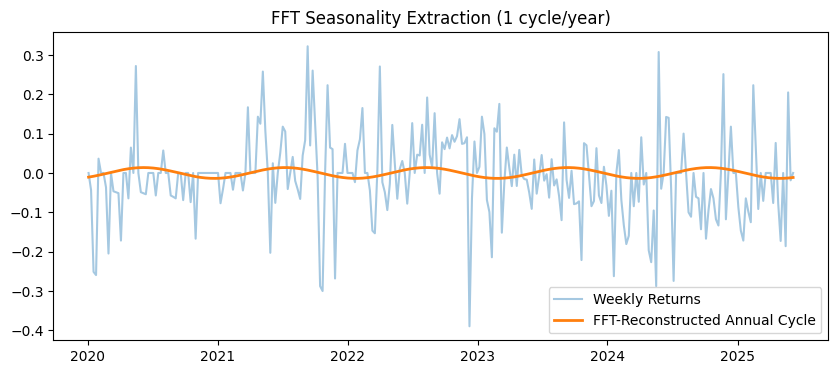

FFT cycle R²: -0.0018


In [13]:
weekly = (
    spot['return_cleaned']
        .resample('W-FRI')
        .sum()
        .dropna()
)
y = weekly.values
n = len(y)

fft_vals = np.fft.fft(y)
freqs    = np.fft.fftfreq(n, d=1)   

annual_idx = np.argmin(np.abs(freqs - 1/52.0))
mirror_idx = np.argmin(np.abs(freqs + 1/52.0))

fft_filt = np.zeros_like(fft_vals)
fft_filt[annual_idx]      = fft_vals[annual_idx]
fft_filt[mirror_idx]      = fft_vals[mirror_idx]
fft_filt[0]               = 0            # drop the mean if you only want pure cycle

seasonal = np.fft.ifft(fft_filt).real

plt.figure(figsize=(10,4))
plt.plot(weekly.index, y,        label='Weekly Returns', alpha=0.4)
plt.plot(weekly.index, seasonal, label='FFT-Reconstructed Annual Cycle', linewidth=2)
plt.legend()
plt.title("FFT Seasonality Extraction (1 cycle/year)")
plt.show()

from sklearn.metrics import r2_score

r2 = r2_score(y, seasonal)
print("FFT cycle R²:", round(r2, 4))

## Monthly scale (NOTE: Clear results, makes sense for compliance)

C:\Users\esurujiu\AppData\Local\Temp\ipykernel_24124\1319374827.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')        # group into end-of-month buckets


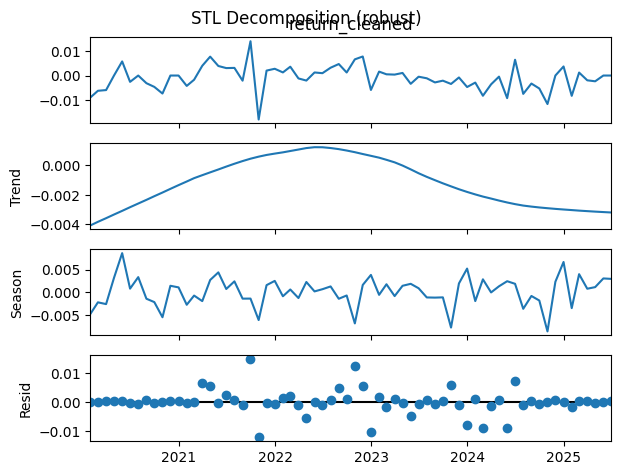

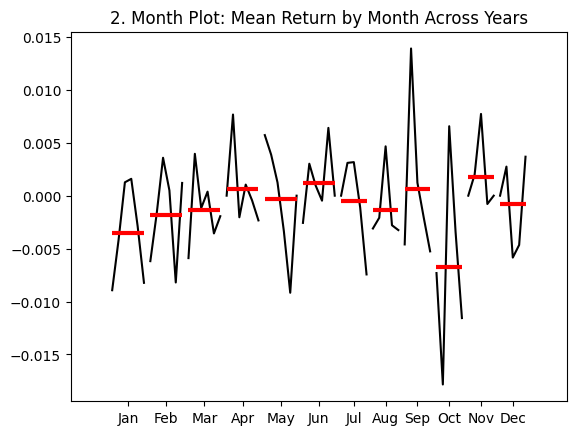

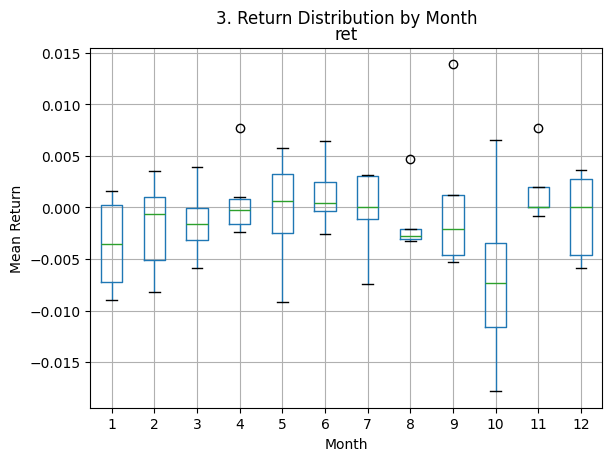

In [14]:
monthly = (
    spot['return_cleaned']
      .resample('M')        # group into end-of-month buckets
      .mean()               # average within each month
      .dropna()             # seasonal_decompose won’t accept any NaNs
)

stl = STL(monthly, period=12, robust=True)
res = stl.fit()
fig = res.plot()
fig.suptitle("STL Decomposition (robust)") 


fig, ax = plt.subplots()
month_plot(monthly, ax=ax)
ax.set_title("2. Month Plot: Mean Return by Month Across Years")
plt.show()

df = monthly.to_frame(name='ret')
df['month'] = df.index.month
fig, ax = plt.subplots()
df.boxplot(column='ret', by='month', ax=ax)
plt.suptitle("3. Return Distribution by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Mean Return")
plt.show()


In [15]:
# 1) resample to get one return per calendar month
monthly_ret = (
    spot['return_cleaned']
      .resample('M')    # bucket by month‐end
      .mean()           # average within each month
      .dropna()         # drop any months with no data
)

# 2) stick it into a DataFrame and extract month
dfm = monthly_ret.to_frame(name='return_cleaned')
dfm['month'] = dfm.index.month

# 3) build our design matrix from that same df
dummies = pd.get_dummies(dfm['month'], prefix='m', drop_first=True, dtype=float)
X = sm.add_constant(dummies)         # automatically gets the dfm.index
y = dfm['return_cleaned']

# 4) fit with HAC(1) SEs
model_m = sm.OLS(y, X, missing='drop')\
            .fit(cov_type='HAC', cov_kwds={'maxlags':1})

print(model_m.summary())


                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.450
Date:                Mon, 30 Jun 2025   Prob (F-statistic):              0.178
Time:                        09:08:01   Log-Likelihood:                 262.78
No. Observations:                  66   AIC:                            -501.6
Df Residuals:                      54   BIC:                            -475.3
Df Model:                          11                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -2.123      0.0

C:\Users\esurujiu\AppData\Local\Temp\ipykernel_24124\1960829477.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')    # bucket by month‐end


In [12]:
model_nw = model_m.get_robustcov_results(
    cov_type = 'HAC',
    maxlags = 1 
)

model_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.450
Date:                Wed, 25 Jun 2025   Prob (F-statistic):              0.178
Time:                        09:22:15   Log-Likelihood:                 262.78
No. Observations:                  66   AIC:                            -501.6
Df Residuals:                      54   BIC:                            -475.3
Df Model:                          11                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -2.123      0.034      -0.007      -0.000
m_2            0.0018      0.002      0.831      0.406      -0.002       0.006
m_3            0.0022      0.002      1.043      0.297      -0.002       0.006
m_4            0.0042      0.002      1.946      0.052   -2.95e-05       0.008
m_5            0.0033      0.003      1.256      0.209      -0.002       0.008
m_6            0.0048      0.002      2.342      0.019       0.001       0.009
m_7            0.0031      0.002      1.287      0.198      -0.002       0.008
m_8            0.0022      0.002      1.045      0.296      -0.002       0.006
m_9            0.0042      0.004      1.180      0.238      -0.003       0.011
m_10          -0.0031      0.004     -0.782      0.434      -0.011       0.005
m_11           0.0054      0.002      2.456      0.014       0.001       0.010
m_12           0.0027      0.003      1.049      0.294      -0.002       0.008
==============================================================================
Omnibus:                        4.952   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.178
Skew:                           0.456   Prob(JB):                        0.124
Kurtosis:                       3.829   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

## Final check 

# Model Extension


## Normality/Autocorrelation

In [15]:
weekly = spot[['return_cleaned']].resample('W-MON').mean().dropna()

In [16]:
r = (weekly['return_cleaned'] * 100).dropna()        # % returns

def describe_returns(r):
    r = r.dropna()
    stats = {
        'obs'     : len(r),
        'mean'    : r.mean(),
        'std'     : r.std(),
        'skew'    : r.skew(),
        'kurt'    : r.kurtosis(),
        'min'     : r.min(),
        'max'     : r.max(),
        'VaR_95'  : r.quantile(0.05),
        'ES_95'   : r[r <= r.quantile(0.05)].mean()
    }
    return pd.Series(stats, name='Hydro spot returns')

summary = describe_returns(r)  # scale to %
print(summary.round(3))

jb_p   = st.jarque_bera(r).pvalue
print(f"Jarque-Bera p = {jb_p:.4e}")

obs       283.000
mean       -0.115
std         0.811
skew       -0.520
kurt        1.943
min        -3.334
max         2.266
VaR_95     -1.655
ES_95      -2.166
Name: Hydro spot returns, dtype: float64
Jarque-Bera p = 1.3634e-12


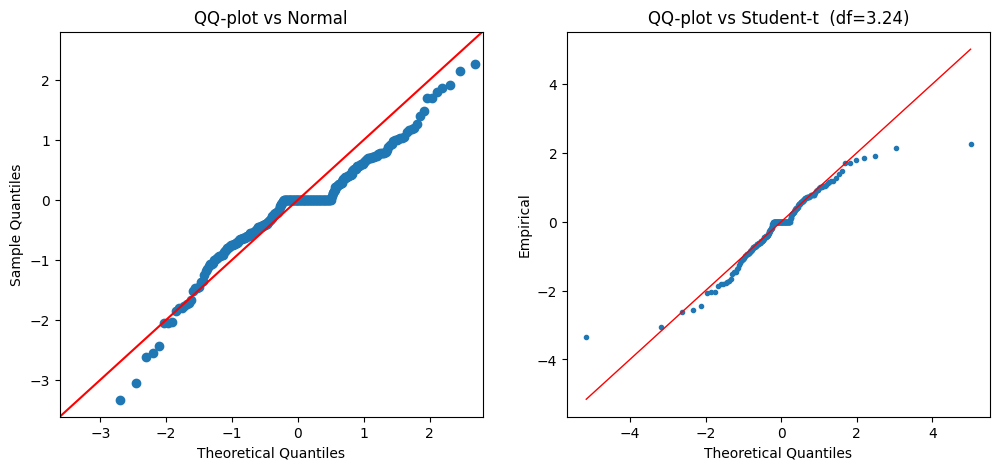

In [17]:
df_t, loc_t, scale_t = st.t.fit(r)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sm.qqplot(r, line='45', ax=axes[0])
axes[0].set_title('QQ-plot vs Normal')

q_theor = st.t.ppf(np.linspace(0.001, 0.999, len(r)), df_t, loc_t, scale_t)
q_emp = np.sort(r.values)

axes[1].plot(q_theor, q_emp, marker='o', linestyle='', ms=3)
axes[1].plot(q_theor, q_theor, color='r', lw=1)
axes[1].set_title(f'QQ-plot vs Student-t  (df={df_t:.2f})')
axes[1].set_xlabel('Theoretical Quantiles'); axes[1].set_ylabel('Empirical')

plt.show()

Gaussian μ=-0.115, σ=0.810
Student-t ν=3.20, scale=0.555


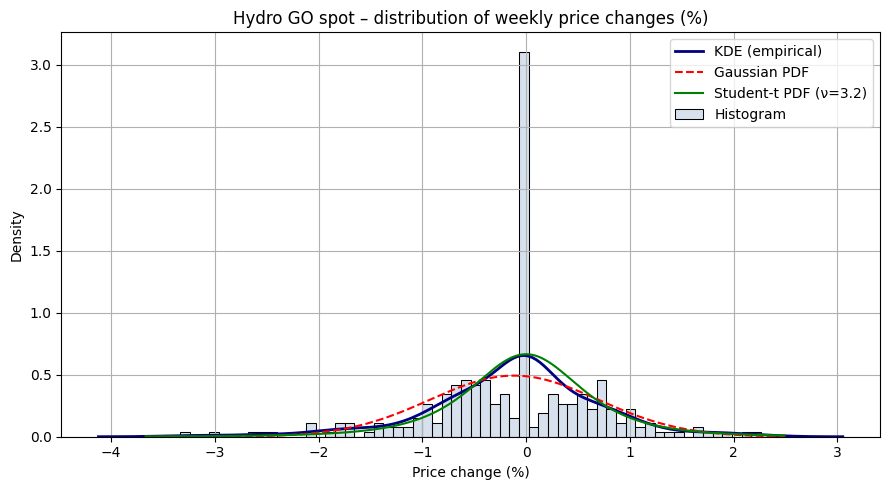

In [140]:
mu,  std  = st.norm.fit(r)            # Gaussian
df_t, loc_t, scale_t = st.t.fit(r, floc=0)  # Student-t, mean fixed at 0

print(f"Gaussian μ={mu:.3f}, σ={std:.3f}")
print(f"Student-t ν={df_t:.2f}, scale={scale_t:.3f}")

fig, ax = plt.subplots(figsize=(9,5))

# histogram
sns.histplot(r, bins=60, stat='density', color='lightsteelblue',
             edgecolor='k', alpha=0.5, ax=ax, label='Histogram')

# KDE (empirical smooth curve)
sns.kdeplot(r, color='navy', lw=2, ax=ax, label='KDE (empirical)')

# overlay Gaussian PDF
x = np.linspace(r.min()*1.1, r.max()*1.1, 500)
ax.plot(x, st.norm.pdf(x, mu, std), 'r--', lw=1.5, label='Gaussian PDF')

# overlay Student-t PDF
ax.plot(x, st.t.pdf(x, df_t, loc_t, scale_t), 'g-', lw=1.5,
        label=f'Student-t PDF (ν={df_t:.1f})')

# cosmetics
ax.set_title('Hydro GO spot – distribution of weekly price changes (%)')
ax.set_xlabel('Price change (%)'); ax.set_ylabel('Density')
ax.legend(); ax.grid(True); plt.tight_layout(); plt.show()

In [19]:
garch_t = arch_model(
        r,
        mean='AR',    # keep μ free
        vol='GARCH', p=1, q=1,
        dist='t'            # heavy-tail
    ).fit(update_freq=0)

print(garch_t.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 317.3960554818571
            Iterations: 14
            Function evaluations: 95
            Gradient evaluations: 14
                              AR - GARCH Model Results                              
Dep. Variable:               return_cleaned   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -317.396
Distribution:      Standardized Student's t   AIC:                           644.792
Method:                  Maximum Likelihood   BIC:                           663.019
                                              No. Observations:                  283
Date:                      Wed, Jun 25 2025   Df Residuals:                      282
Time:                              09:23:53   Df Model:                            1
                          

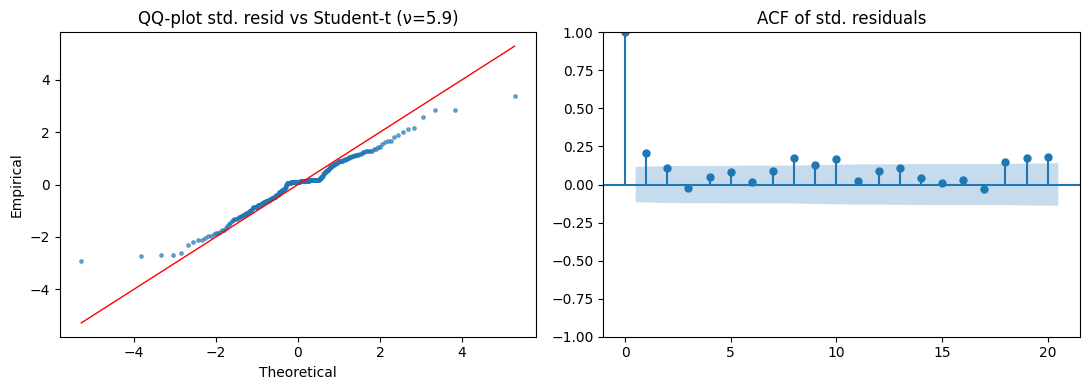

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

std_res   = garch_t.std_resid.dropna()
cond_vol  = garch_t.conditional_volatility

nu  = garch_t.params['nu']                       # fitted df
loc = 0                                          # mean of std. resid
scale = 1                                        # std. resid are unit-variance

q_theor = st.t.ppf(np.linspace(0.001, 0.999, len(std_res)), df=nu, loc=loc, scale=scale)
q_emp   = np.sort(std_res.values)

axs[0].scatter(q_theor, q_emp, s=6, alpha=0.6)
axs[0].plot(q_theor, q_theor, 'r', lw=1)         # 45-degree line
axs[0].set_title(f'QQ-plot std. resid vs Student-t (ν={nu:.1f})')
axs[0].set_xlabel('Theoretical'); axs[0].set_ylabel('Empirical')

sm.graphics.tsa.plot_acf(std_res, lags=20, ax=axs[1])
axs[1].set_title('ACF of std. residuals')
plt.tight_layout(); plt.show()

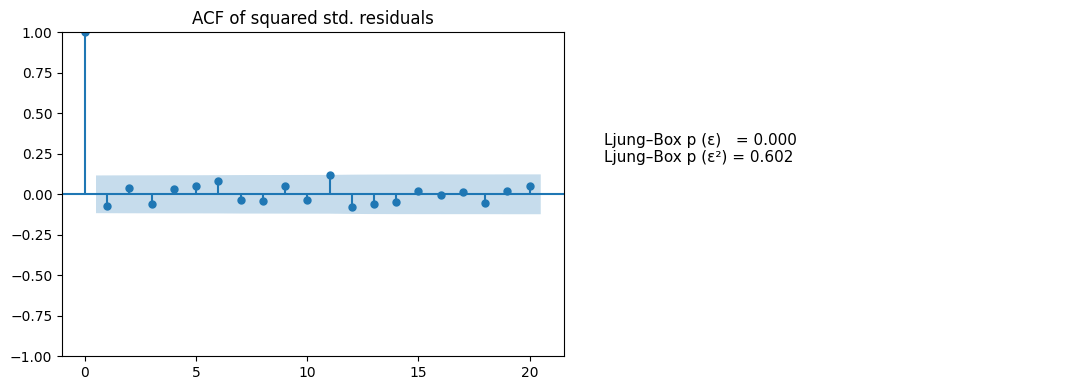

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

sm.graphics.tsa.plot_acf(std_res**2, lags=20, ax=ax[0])
ax[0].set_title('ACF of squared std. residuals')

lb_raw = acorr_ljungbox(std_res,    lags=[20], return_df=True)['lb_pvalue'].iloc[0]
lb_sq  = acorr_ljungbox(std_res**2, lags=[20], return_df=True)['lb_pvalue'].iloc[0]

ax[1].axis('off')
ax[1].text(0.05, 0.6,
           f'Ljung–Box p (ε)   = {lb_raw:5.3f}\n'
           f'Ljung–Box p (ε²) = {lb_sq:5.3f}',
           fontsize=11)

plt.tight_layout(); plt.show()

## Exogeneous variables

### Hydro level

In [22]:
weekly

,return_cleaned
Modified on,
2020-01-06,0.000000
2020-01-13,-0.005074
2020-01-20,-0.015164
2020-01-27,-0.020572
2020-02-03,0.010303
...,...
2025-05-12,-0.002241
2025-05-19,-0.000777
2025-05-26,0.003737


In [23]:
water = water.set_index('Date').sort_index()

In [24]:
water

,Country,Region,Year,Week,StoredEnergy
Date,,,,,
2018-12-31,Austria,Alps,2019,1,1412194.0
2018-12-31,France,Alps,2019,1,2186488.0
2018-12-31,Norway,Nordics,2019,1,51526000.0
2018-12-31,Sweden,Nordics,2019,1,18035000.0
2018-12-31,Switzerland,Alps,2019,1,4656491.0
...,...,...,...,...,...
2025-06-09,Norway,Nordics,2025,24,52334103.0
2025-06-09,France,Alps,2025,24,2327220.0
2025-06-09,Austria,Alps,2025,24,717068.0


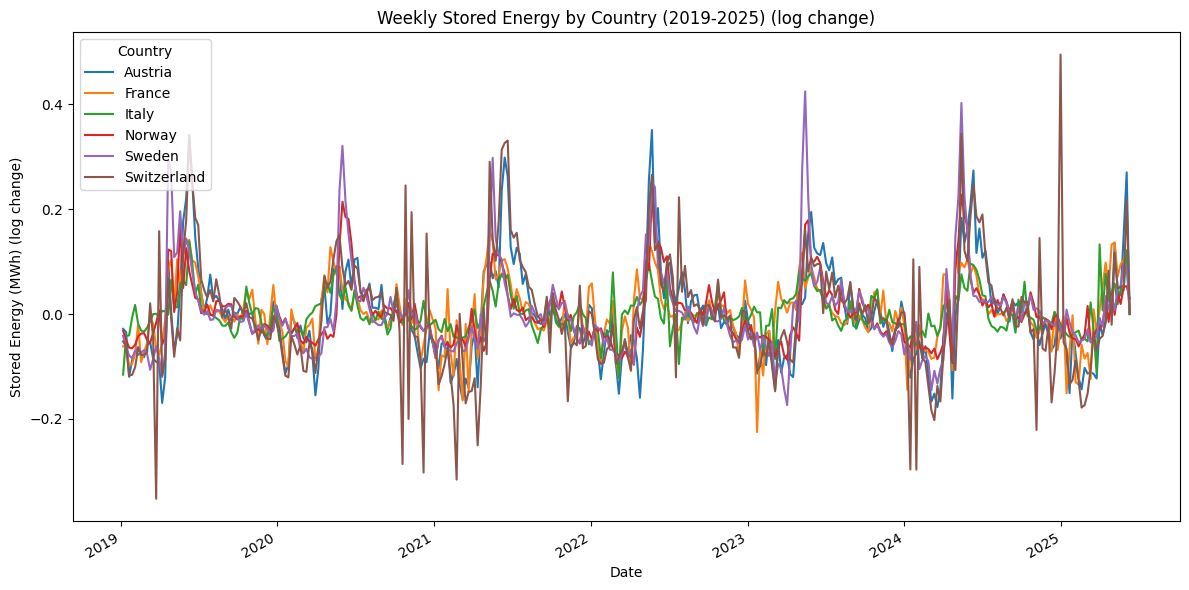

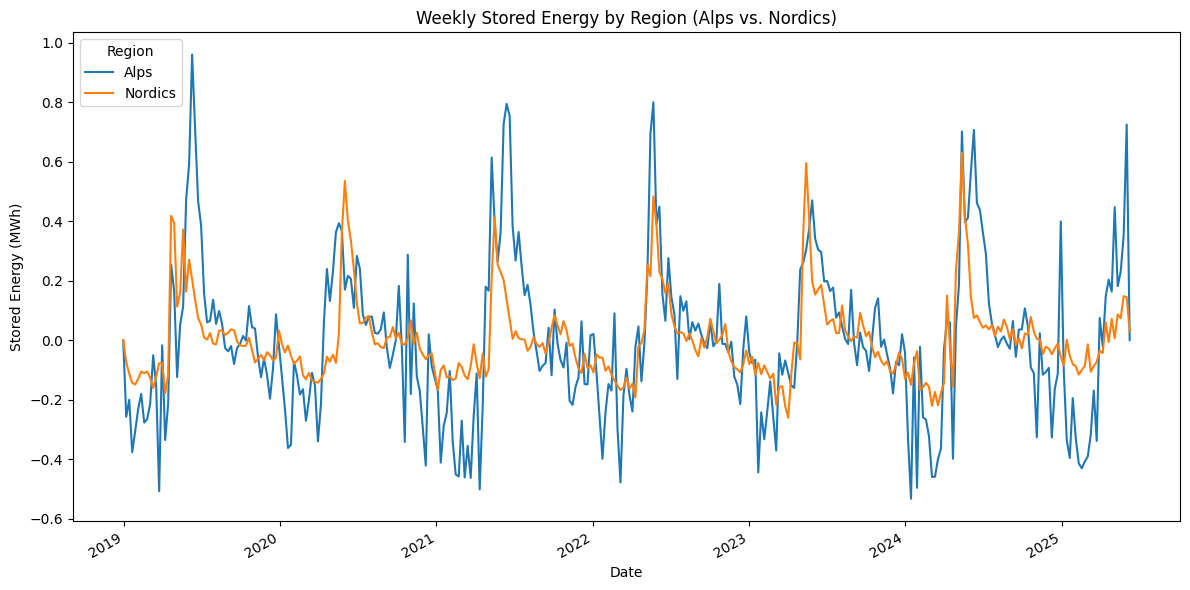

In [164]:
water['dStorage'] = water.groupby('Country')['StoredEnergy'].diff()

water['logStorage'] = np.log(water['StoredEnergy'])
water['dlogStorage'] = water.groupby('Country')['logStorage'].diff()


pivot_country = (
    water.pivot_table(
        index='Date',
        columns='Country',
        values='dlogStorage',
        aggfunc='mean'     # change to 'mean' if you prefer averages
    )
    .sort_index()
)
plt.figure(figsize=(12, 6))
pivot_country.plot(ax=plt.gca())
plt.title('Weekly Stored Energy by Country (2019-2025) (log change)')
plt.xlabel('Date')
plt.ylabel('Stored Energy (MWh) (log change)')
plt.legend(title='Country', loc='upper left')
plt.tight_layout()
plt.show()


# 5. -------- Plot 2: regional graph --------
pivot_region = (
    water.groupby(['Date', 'Region'])['dlogStorage']
    .sum()
    .unstack('Region')
    .sort_index()
)

plt.figure(figsize=(12, 6))
pivot_region.plot(ax=plt.gca())
plt.title('Weekly Stored Energy by Region (Alps vs. Nordics)')
plt.xlabel('Date')
plt.ylabel('Stored Energy (MWh)')
plt.legend(title='Region', loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
# 2. Aggregate log-diff storage by region
region_storage = (
    water
    .groupby(['Region', 'Date'])['dlogStorage']
    .sum()
    .unstack('Region')  # columns: Alps, Nordics
    .rename(columns={'Alps': 'dlogStorage_Alps', 'Nordics': 'dlogStorage_Nordics'})
    .reset_index()
)

# 3. (Optional) EU-wide average storage change
region_storage['dlogStorage_EU'] = region_storage[['dlogStorage_Alps','dlogStorage_Nordics']].sum(axis=1)

# 4. Merge returns with storage regressors
df = weekly.merge(
    region_storage,
    left_on='Modified on',
    right_on='Date',
    how='inner'
).dropna(subset=['return_cleaned'])  # ensure no missing returns

# 5. Prepare design matrices
# Example A: Two-region model
X_region = df[['dlogStorage_Alps', 'dlogStorage_Nordics']]
X_region = sm.add_constant(X_region)
y = df['return_cleaned']

model_region = sm.OLS(y, X_region).fit()
print("=== Region-level Regressors ===")
print(model_region.summary())

# Example B: EU-average model
X_eu = sm.add_constant(df[['dlogStorage_EU']])
model_eu = sm.OLS(y, X_eu).fit()
print("\n=== EU-average Regressor ===")
print(model_eu.summary())


=== Region-level Regressors ===
                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.580
Date:                Wed, 25 Jun 2025   Prob (F-statistic):            0.00421
Time:                        09:24:47   Log-Likelihood:                 962.98
No. Observations:                 282   AIC:                            -1920.
Df Residuals:                     279   BIC:                            -1909.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
co

In [27]:
X = df[['dlogStorage_Alps','dlogStorage_Nordics']].dropna()

print("Corr:", X.corr().iloc[0,1])


Corr: 0.6718253853093824


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.Series(
    [variance_inflation_factor(X.values, i) 
     for i in range(X.shape[1])],
    index=X.columns
)
print("VIFs:\n", vif)

VIFs:
 dlogStorage_Alps       1.820681
dlogStorage_Nordics    1.820681
dtype: float64


In [29]:
aux = sm.OLS(df['dlogStorage_Nordics'], sm.add_constant(df['dlogStorage_Alps'])).fit()
df['Nordics_resid'] = aux.resid
model = sm.OLS(df['return_cleaned'], sm.add_constant(
    df[['dlogStorage_Alps','Nordics_resid']]
)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.580
Date:                Wed, 25 Jun 2025   Prob (F-statistic):            0.00421
Time:                        09:25:02   Log-Likelihood:                 962.98
No. Observations:                 282   AIC:                            -1920.
Df Residuals:                     279   BIC:                            -1909.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0011      0.000     -2.364      0.019      -0.002      -0.000
dlogStorage_Alps     0.0028      0.002      1.492      0.137      -0.001       0.006
Nordics_resid       -0.0140      0.005     -2.989      0.003      -0.023      -0.005
==============================================================================
Omnibus:                       26.366   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.866
Skew:                          -0.503   Prob(JB):                     5.46e-12
Kurtosis:                       4.844   Cond. No.                         9.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Hydro + seasonality

In [41]:
print('---------------Storage---------------')
print(water.head())

print('\n---------------Price change---------------')
print(weekly.head())

---------------Storage---------------
                Country   Region  Year  Week  StoredEnergy  dStorage  \
Date                                                                   
2018-12-31      Austria     Alps  2019     1     1412194.0       NaN   
2018-12-31       France     Alps  2019     1     2186488.0       NaN   
2018-12-31       Norway  Nordics  2019     1    51526000.0       NaN   
2018-12-31       Sweden  Nordics  2019     1    18035000.0       NaN   
2018-12-31  Switzerland     Alps  2019     1     4656491.0       NaN   

            logStorage  dlogStorage  
Date                                 
2018-12-31   14.160655          NaN  
2018-12-31   14.597807          NaN  
2018-12-31   17.757597          NaN  
2018-12-31   16.707825          NaN  
2018-12-31   15.353773          NaN  

---------------Price change---------------
             return_cleaned
Modified on                
2020-01-06         0.000000
2020-01-13        -0.005074
2020-01-20        -0.015164
2020-01

In [55]:
storage_df_reset = water.reset_index()[['Date', 'Region', 'dlogStorage']]
price_df_reset   = weekly.reset_index()[['Modified on', 'return_cleaned']]

region_wide = storage_df_reset.pivot_table(
    index='Date',
    columns='Region',
    values='dlogStorage'
).rename(columns=lambda x: f"dlog_{x}")


In [57]:
regr = price_df_reset.set_index('Modified on').join(region_wide, how='inner').reset_index()


In [ ]:
regr['month'] = regr['index'].dt.month.astype('category')

In [86]:
import statsmodels.formula.api as smf

model = smf.ols(
    'return_cleaned ~ dlog_Alps + dlog_Nordics + C(month)',
    data=regr
).fit(cov_type='HAC', cov_kwds={'maxlags':1})

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.640
Date:                Wed, 25 Jun 2025   Prob (F-statistic):             0.0744
Time:                        15:39:04   Log-Likelihood:                 969.65
No. Observations:                 282   AIC:                            -1911.
Df Residuals:                     268   BIC:                            -1860.
Df Model:                          13                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0042      0.002     -2.558      0.011      -0.007      -0.001
C(month)[T.2]      0.0033      0.002      1.508      0.131      -0.001       0.008
C(month)[T.3]      0.0004      0.002      0.199      0.842      -0.004       0.004
C(month)[T.4]      0.0019      0.002      0.966      0.334      -0.002       0.006
C(month)[T.5]      0.0059      0.003      2.142      0.032       0.001       0.011
C(month)[T.6]      0.0054      0.003      2.110      0.035       0.000       0.010
C(month)[T.7]      0.0039      0.002      1.611      0.107      -0.001       0.009
C(month)[T.8]      0.0036      0.002      1.746      0.081      -0.000       0.008
C(month)[T.9]      0.0051      0.003      1.960      0.050   -9.08e-07       0.010
C(month)[T.10]    -0.0001      0.003     -0.050      0.960      -0.006       0.006
C(month)[T.11]     0.0050      0.003      1.786      0.074      -0.000       0.011
C(month)[T.12]     0.0034      0.002      1.768      0.077      -0.000       0.007
dlog_Alps          0.0193      0.011      1.705      0.088      -0.003       0.041
dlog_Nordics      -0.0365      0.011     -3.218      0.001      -0.059      -0.014
==============================================================================
Omnibus:                       27.664   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.714
Skew:                          -0.539   Prob(JB):                     3.57e-12
Kurtosis:                       4.823   Cond. No.                         30.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [145]:
model = smf.ols(
    'return_cleaned ~ dlog_Alps* C(month) + dlog_Nordics* C(month)',
    data=regr
).fit(cov_type='HAC', cov_kwds={'maxlags':1})

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     2.162
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           0.000376
Time:                        12:57:07   Log-Likelihood:                 981.30
No. Observations:                 282   AIC:                            -1891.
Df Residuals:                     246   BIC:                            -1759.
Df Model:                          35                                         
Covariance Type:                  HAC                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0053      0.003     -1.679      0.093      -0.011       0.001
C(month)[T.2]                   0.0178      0.007      2.492      0.013       0.004       0.032
C(month)[T.3]                   0.0017      0.005      0.329      0.742      -0.008       0.012
C(month)[T.4]                   0.0034      0.003      1.002      0.316      -0.003       0.010
C(month)[T.5]                   0.0062      0.004      1.533      0.125      -0.002       0.014
C(month)[T.6]                   0.0093      0.004      2.376      0.017       0.002       0.017
C(month)[T.7]                   0.0095      0.004      2.288      0.022       0.001       0.018
C(month)[T.8]                   0.0051      0.003      1.479      0.139      -0.002       0.012
C(month)[T.9]                   0.0049      0.004      1.362      0.173      -0.002       0.012
C(month)[T.10]                  0.0008      0.004      0.220      0.826      -0.007       0.008
C(month)[T.11]                  0.0078      0.004      2.003      0.045       0.000       0.016
C(month)[T.12]                  0.0076      0.005      1.690      0.091      -0.001       0.016
dlog_Alps                       0.0249      0.033      0.762      0.446      -0.039       0.089
dlog_Alps:C(month)[T.2]         0.0470      0.045      1.046      0.295      -0.041       0.135
dlog_Alps:C(month)[T.3]        -0.0551      0.039     -1.403      0.161      -0.132       0.022
dlog_Alps:C(month)[T.4]         0.0040      0.048      0.082      0.935      -0.091       0.099
dlog_Alps:C(month)[T.5]         0.0181      0.055      0.331      0.741      -0.089       0.125
dlog_Alps:C(month)[T.6]        -0.0281      0.036     -0.777      0.437      -0.099       0.043
dlog_Alps:C(month)[T.7]        -0.0897      0.082     -1.100      0.272      -0.250       0.070
dlog_Alps:C(month)[T.8]        -0.0386      0.062     -0.627      0.531      -0.159       0.082
dlog_Alps:C(month)[T.9]        -0.3647      0.124     -2.946      0.003      -0.607      -0.122
dlog_Alps:C(month)[T.10]        0.0683      0.057      1.200      0.230      -0.043       0.180
dlog_Alps:C(month)[T.11]        0.0419      0.083      0.503      0.615      -0.121       0.205
dlog_Alps:C(month)[T.12]        0.0246      0.047      0.525      0.599      -0.067       0.116
dlog_Nordics                   -0.0724      0.050     -1.455      0.146      -0.170       0.025
dlog_Nordics:C(month)[T.2]      0.2152      0.112      1.922      0.055      -0.004       0.435
dlog_Nordics:C(month)[T.3]      0.0887      0.074      1.201      0.230      -0.056       0.233
dlog_Nordics:C(month)[T.4]      0.0471      0.059      0.793      0.428      -0.069       0.164
dlog_Nordics:C(month)[T.5]      0.0243      0.054      0.448      0.654      -0.082       0.131
dlog_Nordic

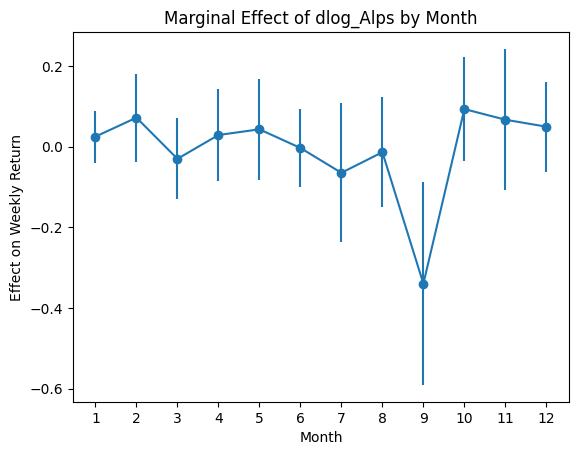

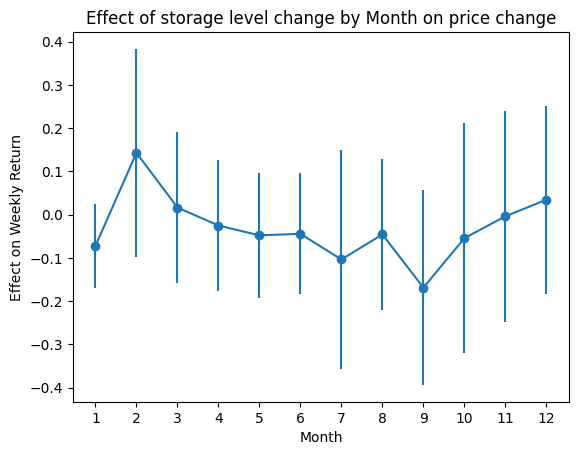

In [150]:
params = model.params
ses    = model.bse

months = list(range(1, 13))

# 2) Compute marginal effects and 95% CI error bars for Alps
alp_base = params['dlog_Alps']
alp_se   = ses['dlog_Alps']
alp_effects, alp_errs = [], []
for m in months:
    if m == 1:
        coeff = alp_base
        se    = alp_se
    else:
        inter_key = f'dlog_Alps:C(month)[T.{m}]'
        coeff = alp_base + params.get(inter_key, 0)
        se    = (alp_se**2 + ses.get(inter_key, 0)**2) ** 0.5
    alp_effects.append(coeff)
    alp_errs.append(se * 1.96)

# 3) Plot Alps marginal effect by month
plt.figure()
plt.errorbar(months, alp_effects, yerr=alp_errs, marker='o')
plt.xticks(months)
plt.title('Marginal Effect of dlog_Alps by Month')
plt.xlabel('Month')
plt.ylabel('Effect on Weekly Return')
plt.show()

# 4) Compute for Nordics
nod_base = params['dlog_Nordics']
nod_se   = ses['dlog_Nordics']
nod_effects, nod_errs = [], []
for m in months:
    if m == 1:
        coeff = nod_base
        se    = nod_se
    else:
        inter_key = f'dlog_Nordics:C(month)[T.{m}]'
        coeff = nod_base + params.get(inter_key, 0)
        se    = (nod_se**2 + ses.get(inter_key, 0)**2) ** 0.5
    nod_effects.append(coeff)
    nod_errs.append(se * 1.96)

# 5) Plot Nordics marginal effect by month
plt.figure()
plt.errorbar(months, nod_effects, yerr=nod_errs, marker='o')
plt.xticks(months)
plt.title('Effect of storage level change by Month on price change')
plt.xlabel('Month')
plt.ylabel('Effect on Weekly Return')
plt.show()

In [531]:
# 1) Define the spread variable
regr['dlog_diff'] = regr['dlog_Nordics'] - regr['dlog_Alps']

regr['dlog_lagged'] = regr['dlog_diff'].shift(1)

# 2) Regress on the spread + seasonality (e.g. your Fourier terms)
model = smf.ols(
    'return_cleaned ~ dlog_lagged',
    data=regr
).fit(cov_type='HAC', cov_kwds={'maxlags':1})

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.204
Date:                Fri, 27 Jun 2025   Prob (F-statistic):             0.0413
Time:                        15:46:42   Log-Likelihood:                 956.13
No. Observations:                 281   AIC:                            -1908.
Df Residuals:                     279   BIC:                            -1901.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0011      0.001     -2.131      

In [134]:
regr['t'] = np.arange(len(df))                         # or use day-of-year / week-of-year
regr['sin2'] = np.sin(4*np.pi*regr['t']/52.18)
regr['cos2'] = np.cos(4*np.pi*regr['t']/52.18)
model = smf.ols("return_cleaned ~ dlog_diff + sin_seas + cos_seas",
                data=regr).fit(cov_type='HAC', cov_kwds={'maxlags':1})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.299
Date:                Thu, 26 Jun 2025   Prob (F-statistic):             0.0209
Time:                        10:53:17   Log-Likelihood:                 963.29
No. Observations:                 282   AIC:                            -1919.
Df Residuals:                     278   BIC:                            -1904.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0011      0.001     -2.040      0.0

In [123]:
model = smf.ols(
    'return_cleaned ~ dlog_Alps + dlog_Nordics + C(month)',
    data=regr
).fit(cov_type='HAC', cov_kwds={'maxlags':1})

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.658
Date:                Wed, 25 Jun 2025   Prob (F-statistic):             0.0774
Time:                        17:13:29   Log-Likelihood:                 817.84
No. Observations:                 239   AIC:                            -1610.
Df Residuals:                     226   BIC:                            -1564.
Df Model:                          12                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0026      0.001     -1.788      0.074      -0.005       0.000
C(month)[T.2]      0.0027      0.002      1.220      0.223      -0.002       0.007
C(month)[T.3]      0.0003      0.002      0.147      0.883      -0.003       0.004
C(month)[T.4]      0.0018      0.002      0.866      0.387      -0.002       0.006
C(month)[T.5]      0.0008      0.003      0.299      0.765      -0.005       0.006
C(month)[T.6]      0.0034      0.002      1.747      0.081      -0.000       0.007
C(month)[T.7]      0.0022      0.003      0.832      0.405      -0.003       0.007
C(month)[T.8]      0.0024      0.002      1.272      0.203      -0.001       0.006
C(month)[T.9]      0.0045      0.003      1.691      0.091      -0.001       0.010
C(month)[T.10]    -0.0023      0.003     -0.670      0.503      -0.009       0.004
C(month)[T.11]     0.0030      0.003      1.126      0.260      -0.002       0.008
C(month)[T.12]     0.0025      0.002      1.363      0.173      -0.001       0.006
dlog_lagged        0.0212      0.008      2.812      0.005       0.006       0.036
==============================================================================
Omnibus:                       25.634   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.718
Skew:                          -0.581   Prob(JB):                     7.17e-11
Kurtosis:                       4.828   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

lags = range(0, 9)                # 0–8 weeks
cc  = ccf(regr['dlog_diff'], regr['return_cleaned'])[:len(lags)]

plt.stem(lags, cc)
plt.xlabel('Lag (weeks)')
plt.ylabel('Cross‑corr [storage → price]')
plt.show()


In [132]:
from statsmodels.tsa.stattools import grangercausalitytests

res = grangercausalitytests(
        regr[['return_cleaned', 'dlog_diff']].dropna(), 
        maxlag=8, verbose=False)

for L in res:
    pval = res[L][0]['ssr_ftest'][1]
    print(f"Lag {L}:  p = {pval:.3}")


Lag 1:  p = 0.102
Lag 2:  p = 0.115
Lag 3:  p = 0.0787
Lag 4:  p = 0.111
Lag 5:  p = 0.0961
Lag 6:  p = 0.103
Lag 7:  p = 0.117
Lag 8:  p = 0.088


C:\Users\esurujiu\AppData\Local\miniconda3\envs\GOs\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [152]:
# --- 0) Data already have spread_pct = dlog_Nordics – dlog_Alps
max_lag = 8                        # weekly data → two months is plenty
for L in range(1, max_lag+1):
    regr[f'spread_l{L}'] = regr['dlog_diff'].shift(L)

# keep rows where every required lag is available
base_cols = ['return_cleaned', 'sin_seas', 'cos_seas']
use      = regr.dropna(subset=base_cols + [f'spread_l{L}' for L in range(1, max_lag+1)])


In [155]:
import statsmodels.formula.api as smf

records = []
for L in range(0, max_lag+1):                # 0 = contemporaneous only
    lags = ' + '.join(f'spread_l{i}' for i in range(1, L+1))  # 1…L
    rhs  = ('spread_l0' if L==0 else lags) + ' + sin_seas + cos_seas'
    use['spread_l0'] = use['dlog_diff']     # convenience for L=0
    m = smf.ols(f'return_cleaned ~ {rhs}', data=use).fit(
              cov_type='HAC', cov_kwds={'maxlags':1})
    # Wald test: all lag coefficients = 0
    wald = m.f_test(' + '.join([f'spread_l{i}=0' for i in range(1, L+1)])).pvalue \
           if L>0 else np.nan
    records.append([L, m.rsquared_adj, m.aic, m.bic, wald])

table = pd.DataFrame(records,
        columns=['k_lags','adjR2','AIC','BIC','Wald_p']).set_index('k_lags')
print(table)


           adjR2          AIC          BIC    Wald_p
k_lags                                              
0       0.022886 -1865.043546 -1850.591033       NaN
1       0.006763 -1860.559278 -1846.106766  0.065082
2       0.012992 -1861.299784 -1843.234143  0.068675
3       0.016864 -1861.397239 -1839.718470  0.034452
4       0.018922 -1860.995765 -1835.703868  0.026760
5       0.015333 -1859.023376 -1830.118351  0.050388
6       0.015470 -1858.093507 -1825.575354  0.065737
7       0.012018 -1856.170261 -1820.038980  0.099762
8       0.013265 -1855.556320 -1815.811910  0.137899


C:\Users\esurujiu\AppData\Local\Temp\ipykernel_3008\2630901957.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use['spread_l0'] = use['dlog_diff']     # convenience for L=0
C:\Users\esurujiu\AppData\Local\Temp\ipykernel_3008\2630901957.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use['spread_l0'] = use['dlog_diff']     # convenience for L=0
C:\Users\esurujiu\AppData\Local\Temp\ipykernel_3008\2630901957.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram